In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unrar x '/content/drive/My Drive/WLASL/dataset_standardize(refine2)_boarder_rotation_20.rar'

Mounted at /content/drive

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/My Drive/WLASL/dataset_standardize(refine2)_boarder_rotation_20.rar

Creating    h5                                                        OK
Creating    h5/train_0                                                OK
Extracting  h5/train_0/all_0.h5                                            0%  1%  OK 
Extracting  h5/train_0/all_1.h5                                            1%  OK 
Extracting  h5/train_0/apple_0.h5                                          1%  2%  OK 
Extracting  h5/train_0/ask_0.h5                                            2%  OK 
Extracting  h5/train_0/a_0.h5                                              2%  3%  OK 
Extracting  h5/train_0/basketball_0.h5                                     3%  4%  OK 
Extracting  h5/train_0/bird_0.h5                                    

In [ ]:
!pip install tensorflow-addons
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.layers import Concatenate,Embedding ,Dense ,Input,LSTM,Permute,Softmax,Lambda,Flatten,GRU,Dropout,BatchNormalization, Normalization, Attention, Bidirectional, Masking
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import F1Score, CategoricalAccuracy
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import h5py
from matplotlib import pyplot as plt

def get_one_hot(split):
    import pickle
    from sklearn.preprocessing import OneHotEncoder
    label = pd.read_csv(f'h5/{split}/meta.csv')['Gloss'].to_numpy().reshape(-1,1)
    oe = OneHotEncoder(sparse_output=False)
    oe.fit(label)
    with open('OnehotEncoder.pkl','wb') as f:
      pickle.dump(oe, f)
    return oe

def get_scaler(dataset_name, split, scaler_name='scaler'):
    import pickle
    file = open(f'{split}_{scaler_name}.pkl','rb')
    scaler = pickle.load(file)
    return scaler

class DataGenerator(Sequence):

    def __init__(self, split, dataset_name, oe, batch_size=64, time_series=30, input_shape=(30,225), use_full=False, upsampling=False,**kwargs):
        super().__init__(**kwargs)
        self.split = split
        self.ds_pointer = 0
        self.batch_size = batch_size
        self.dataset_name = dataset_name
        self.time_series = time_series
        self.input_shape = input_shape
        self.use_full = use_full
        self.input_buffer = np.zeros((batch_size,input_shape[0],input_shape[1]))
        self.label_buffer = np.zeros(batch_size)
        self.oe = oe
        self.label_name = oe.get_feature_names_out()
        self.index_df = pd.read_csv(f'h5/{split}/meta.csv')
        if upsampling:
          self.upsample()
        self.data = self.load_file()
        self.reset_pointer()

    def load_file(self):
        result = {}
        # with h5py.File(f'h5/{self.split}_merge.h5','w', rdcc_nbytes=4000*1024**2,rdcc_nslots=1e7) as out:
        #   for label in self.label_name:
        #     label = label.replace('x0_','')
        #     with h5py.File(f'h5/{self.split}/{label}.h5', 'r') as to_merge:
        #       out.create_dataset(label, data=to_merge['data'], chunks=True, maxshape=(None,30,189))

        # h5_doc = h5py.File(f'h5/{self.split}_merge.h5', 'r', rdcc_nbytes=30*1024**2,rdcc_nslots=1e4)
        # for label in self.label_name:
        #   label = label.replace('x0_','')
        #   result[label] = h5_doc[label]
        #   #preload cache
        #   result[label][0:1000]
        for label in self.label_name:
          label = label.replace('x0_','')
          print(label)
          try:
            result[label] = h5py.File(f'h5/{self.split}/{label}.h5', 'r', rdcc_nbytes=100*1024**2, rdcc_nslots=1e4)['data']
          except:
            pass
        return result

    def upsample(self):
      # Find the maximum count of labels in the DataFrame
      max_count = self.index_df['Gloss'].value_counts().max()

      # Define a function to resample and reset index for each group
      def resample_and_reset_index(group):
          resampled_group = group.sample(max_count, replace=True)
          return resampled_group

      # Apply the function to each group and concatenate them back into a single DataFrame
      self.index_df = self.index_df.groupby('Gloss').apply(resample_and_reset_index).reset_index(drop=True)

    def reset_pointer(self, seed = 1314):
        self.index_df = self.index_df.sample(frac=1, random_state=seed)
        self.ds_pointer = 0

    def __len__(self):
      if self.use_full:
        return len(self.index_df)// self.batch_size
      else:
        return len(self.index_df)// self.batch_size// 50

    def num_labels(self):
        return len(self.label_name)

    def resample(self, sample_set, window, max_duplicate=4):
        result = []
        remain = sample_set
        shape_remain = sample_set.shape[0]

        for i in range(sample_set.shape[0]):
            target_row = sample_set[i]
            # Window - (Shape remain) - Current Index
            # Shape remain = sample shape - (i + 1)
            shape_remain = sample_set.shape[0]-i
            random_range = min(window - shape_remain - len(result), max_duplicate) + 1 # Range of random value could be
            random_duplicate = np.random.randint(0, random_range + 1) # The random value to determine how much a sample be duplicated
            for j in range(random_duplicate):
                result.append(target_row)
                if len(result)+shape_remain == window:
                    break
            if len(result)+shape_remain == window:
                break
        result = np.array(result)
        result = np.vstack([result, remain[i:]])
        if result.shape[0] != window: # Fill last row if still some empty space
            to_fill = np.full((window-result.shape[0], result.shape[1]), result[-1])
            result = np.vstack([result, to_fill])
        return result

    def __getitem__(self, index):
        import os
        import numpy as np
        if self.ds_pointer + self.batch_size >= len(self.index_df):
            self.reset_pointer()
            return self.__getitem__(index)
        to_get = self.index_df.iloc[self.ds_pointer:self.ds_pointer+batch_size]
        to_get_index = to_get['Index'].to_numpy()
        to_get_label = to_get['Gloss'].to_numpy()

        for i, label in enumerate(to_get_label):
          self.input_buffer[i, :, :] = self.data[label][to_get_index[i]]

        batch_y = self.oe.transform(to_get_label.reshape(-1,1))
        batch_x = self.input_buffer
        for i in range(self.batch_size):
          # Randomly resample data
          rand_condition = np.random.randint(2)
          if rand_condition == 1:
            start_idx = np.random.randint(batch_x.shape[1]//2)
            end_idx = start_idx + np.random.randint(batch_x.shape[1]-start_idx)
            batch_x[i] = self.resample(batch_x[i][start_idx:start_idx+batch_x.shape[1]//2], window=batch_x.shape[1])


        self.ds_pointer+=self.batch_size
        x_ts = batch_x.shape[1]
        if x_ts != self.time_series:
          batch_x = batch_x[:, x_ts-self.time_series:,:]

        return batch_x, batch_y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:

def build_model(time_series,num_of_features,num_of_labels,scaler=None):
    # model = load_model('encoder.keras', safe_mode=False)
    # layer_names = ['encoder1', 'encoder2', 'encoder3','attention_e1',"decoder3","decoder2","decoder1"]

    # encode_seq1 = model.get_layer(layer_names[0])
    # encode_seq2 = model.get_layer(layer_names[1])
    # encode_seq3 = model.get_layer(layer_names[2])
    # attention_e3 = model.get_layer(layer_names[3])
    # decode_seq3 = model.get_layer(layer_names[4])
    # decode_seq2 = model.get_layer(layer_names[5])
    # decode_seq1 = model.get_layer(layer_names[6])

    # encode_seq1.trainable = False
    # encode_seq2.trainable = False
    # encode_seq3.trainable = False
    # attention_e3.trainable = False
    # decode_seq3.trainable = False
    # decode_seq2.trainable = False
    # decode_seq1.trainable = False


    K.clear_session()
    input_ = Input(shape=(time_series,num_of_features), name='Input')
    mask = Masking(mask_value=0, input_shape=(time_series,num_of_features),name='Mask_Zeroes')(input_)
    mean = scaler.mean_
    print(mean[0:5])
    var = scaler.var_
    norm = Normalization(mean=mean, variance=var,name='Normalization')
    norm = norm(mask)
    norm = Dense(256)(norm)
    # Define GRU layer
    encoder = GRU(256, return_state=True, return_sequences=True, name='Encoder')
    encoder_outputs, state_h = encoder(norm)

    # # Define attention layer
    attention = Attention(name='Attention')
    context_vector = attention([encoder_outputs, state_h])

    # Concatenate context vector and encoder outputs
    concat_layer = Concatenate(axis=-1, name='Concatenate')
    decoder_combined_context = concat_layer([context_vector, norm])

    # Define decoder
    decoder_gru = GRU(256, return_sequences=True, name='Decoder')

    # Pass the concatenated input through the decoder
    decoder_output = decoder_gru(decoder_combined_context, initial_state=state_h)

    output = Flatten(name='Flatten')(decoder_output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(256,activation="relu")(output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(128, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = BatchNormalization()(output)
    output = Dense(num_of_labels, activation='sigmoid')(output)


    model = Model(inputs = input_ , outputs = output)
    adam_optimizer = Adam(learning_rate=0.0001, clipnorm=1., clipvalue=0.5, weight_decay=1e-7)
    model.compile(loss="categorical_crossentropy",optimizer=adam_optimizer,metrics=[CategoricalAccuracy(),tfa.metrics.F1Score(num_of_labels, average='weighted')])
    model.summary()
    return model
#model = build_model(time_series,num_features,num_of_labels, scaler=scaler)

In [ ]:
# Model Config
data_dir_name = 'dataset_upsampling_resize'
batch_size = 256
time_series = 20
input_shape = (time_series,351)
num_features=input_shape[1]
oe_train0 = get_one_hot('train_0')
# oe_train1 = get_one_hot(data_dir_name, 'train_1')
train0_generator = DataGenerator('train_0', data_dir_name, oe_train0, batch_size=batch_size, time_series=time_series, input_shape=input_shape, upsampling=True)
train1_generator = DataGenerator('val_0', data_dir_name, oe_train0, batch_size=batch_size, time_series=time_series, input_shape=input_shape, use_full=False)
# correct_generator = DataGenerator('train_0', data_dir_name, oe_train0, batch_size=batch_size, time_series=time_series)
# val_generator = DataGenerator('val_0', data_dir_name, oe_train0, batch_size=batch_size, time_series=time_series)
# nothing_generator = DataGenerator('train_0', "predict_wrong_partition", oe_train0, batch_size=batch_size, time_series=time_series)

# Modify this to swap dataset
train_generator = train0_generator
val_generator = train1_generator

num_of_labels = train_generator.num_labels() if train_generator.num_labels() > val_generator.num_labels() \
                                            else val_generator.num_labels()
scaler = get_scaler(data_dir_name, 'train_0')

# Directory Config
neural_path = 'neural_network'
log_path = 'neural_network/log'
save_path_dir='attention_t20_encode_decode'

if not os.path.exists(log_path):
    os.makedirs(log_path)
checkpoint = ModelCheckpoint(
    f'{neural_path}/{save_path_dir}/saved_model.keras',
    verbose=1,
    monitor='val_categorical_accuracy',
    save_weights_only=False,
    save_best_only=True,
    mode='auto')

checkpoint2 = ModelCheckpoint(
    f'/content/drive/My Drive/WLASL/{neural_path}/{save_path_dir}/saved_model.keras',
    verbose=1,
    monitor='val_categorical_accuracy',
    save_weights_only=False,
    save_best_only=True,
    mode='auto')

earlystop = EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

!mkdir neural_network

tensorboard = TensorBoard(log_dir=log_path)
model = build_model(time_series,num_features,num_of_labels, scaler=scaler)

a_0
all_1
apple_0
ask_0
b_0
basketball_0
bird_0
black_0
blue_0
but_0
but_1
c_0
chair_0
cheat_0
cheat_1
clothes_0
cow_0
d_0
dance_0
dark_0
dark_1
dog_0
dog_1
drink_0
e_0
eat_0
enjoy_0
f_0
family_0
finish_0
forget_0
g_0
go_0
h_0
happy_0
happy_1
hearing_0
help_0
i_0
jacket_0
k_0
kiss_1
l_0
language_0
language_1
last_0
last_1
later_1
like_0
like_1
m_0
many_0
meet_0
mother_0
n_0
need_0
no_0
o_0
orange_0
p_0
paint_0
paper_0
play_0
q_0
r_0
right_1
s_0
see_0
sorry_0
t_0
thin_0
thin_1
today_0
tomorrow_0
u_0
v_0
w_0
white_0
x_0
y_0
yes_0
yesterday_0
yesterday_1
z_0
a_0
all_1
apple_0
ask_0
b_0
basketball_0
bird_0
black_0
blue_0
but_0
but_1
c_0
chair_0
cheat_0
cheat_1
clothes_0
cow_0
d_0
dance_0
dark_0
dark_1
dog_0
dog_1
drink_0
e_0
eat_0
enjoy_0
f_0
family_0
finish_0
forget_0
g_0
go_0
h_0
happy_0
happy_1
hearing_0
help_0
i_0
jacket_0
k_0
kiss_1
l_0
language_0
language_1
last_0
last_1
later_1
like_0
like_1
m_0
many_0
meet_0
mother_0
n_0
need_0
no_0
o_0
orange_0
p_0
paint_0
paper_0
play_0
q_0
r_0
r

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[ 0.          0.          0.          0.06118968 -0.16339285]
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 20, 351)]            0         []                            
                                                                                                  
 Mask_Zeroes (Masking)       (None, 20, 351)              0         ['Input[0][0]']               
                                                                                                  
 Normalization (Normalizati  (None, 20, 351)              0         ['Mask_Zeroes[0][0]']         
 on)                                                                                              
                                                                                                  
 dense (Dense)               (No

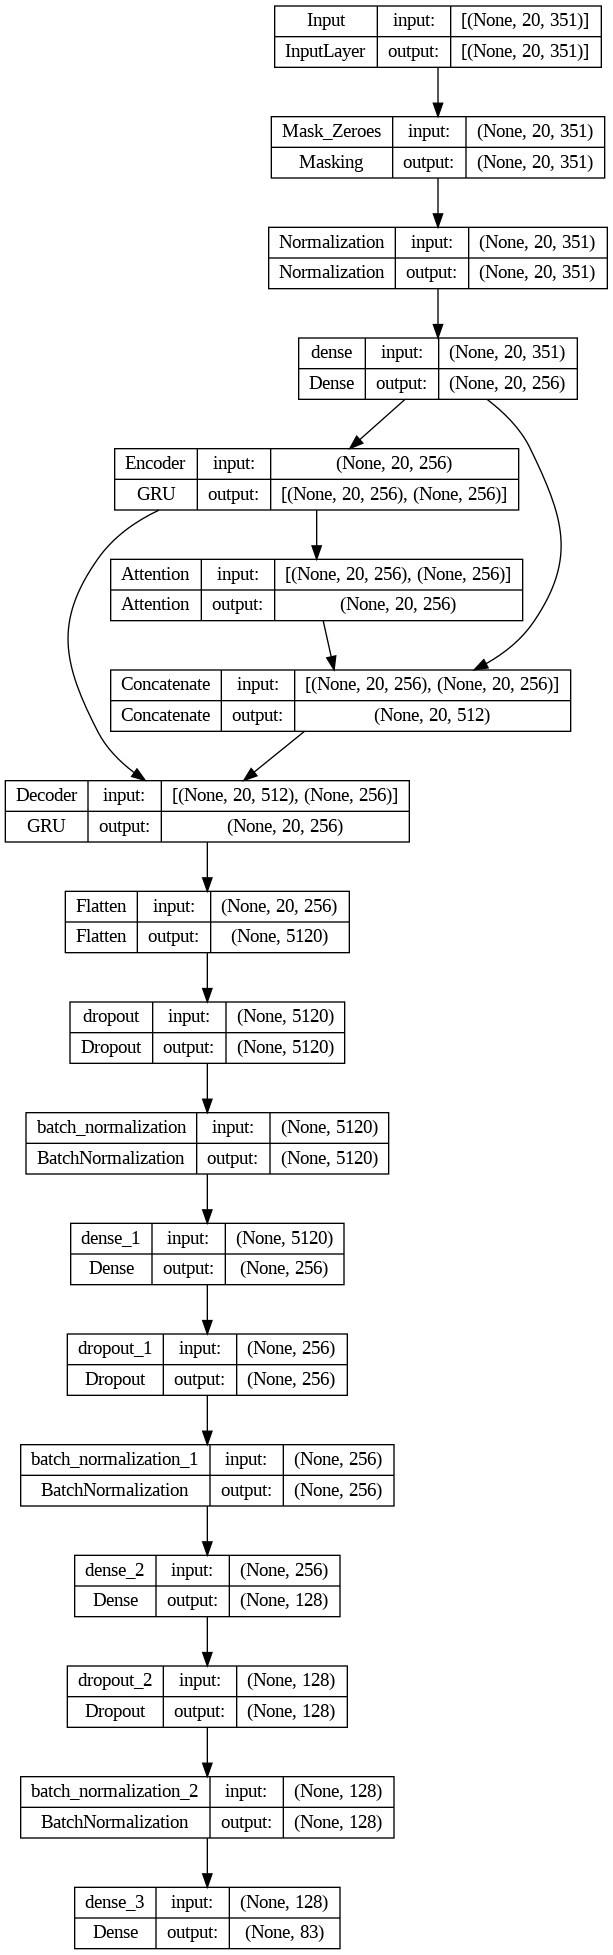

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Epoch 1/2000
196/196 [==============================] - ETA: 0s - loss: 4.0551 - categorical_accuracy: 0.0914 - f1_score: 0.0860
Epoch 1: val_categorical_accuracy improved from -inf to 0.38885, saving model to neural_network/attention_t20_encode_decode/saved_model.keras

Epoch 1: val_categorical_accuracy improved from -inf to 0.38885, saving model to /content/drive/My Drive/WLASL/neural_network/attention_t20_encode_decode/saved_model.keras
196/196 [==============================] - 98s 436ms/step - loss: 4.0551 - categorical_accuracy: 0.0914 - f1_score: 0.0860 - val_loss: 3.0133 - val_categorical_accuracy: 0.3888 - val_f1_score: 0.3603
Epoch 2/2000
196/196 [==============================] - ETA: 0s - loss: 3.0846 - categorical_accuracy: 0.2656 - f1_score: 0.2494
Epoch 2: val_categorical_accuracy improved from 0.38885 to 0.56712, saving model to neural_network/attention_t20_encode_decode/saved_model.keras

Epoch 2: val_categorical_accuracy improved from 0.38885 to 0.56712, saving model 

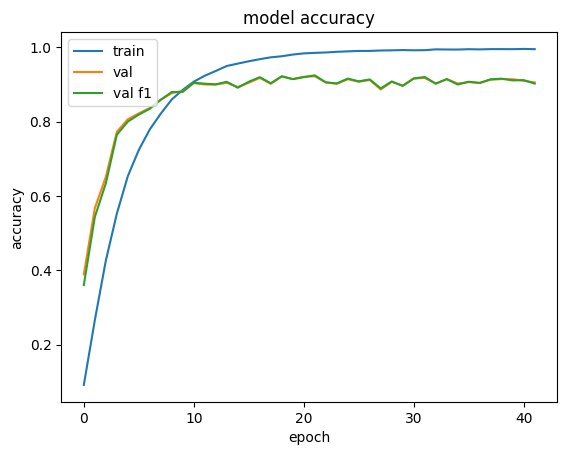

Highest Val Accuracy: 0.9222301244735718
Highest Val F1: 0.9249210357666016


In [ ]:
history = model.fit(train_generator, batch_size=batch_size, epochs=2000, validation_data=val_generator, callbacks=[checkpoint, checkpoint2, earlystop, tensorboard])
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val','val f1'], loc='upper left')
plt.show()
print(f"Highest Val Accuracy: {max(history.history['val_categorical_accuracy'])}")
print(f"Highest Val F1: {max(history.history['val_f1_score'])}")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

with open("model_final.tflite", 'wb') as f:
    f.write(tflite_model)
